In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/model-02-mend/BCD_mendeley/Benign/val/IIR0008_oblleft.jpg
/kaggle/input/model-02-mend/BCD_mendeley/Benign/val/IIR0113_anterior.jpg
/kaggle/input/model-02-mend/BCD_mendeley/Benign/val/IIR0094_anterior.jpg
/kaggle/input/model-02-mend/BCD_mendeley/Benign/val/IIR0001_oblleft.jpg
/kaggle/input/model-02-mend/BCD_mendeley/Benign/val/IIR0022_oblright.jpg
/kaggle/input/model-02-mend/BCD_mendeley/Benign/val/IIR0061_oblright.jpg
/kaggle/input/model-02-mend/BCD_mendeley/Benign/val/IIR0005_oblright.jpg
/kaggle/input/model-02-mend/BCD_mendeley/Benign/val/IIR0067_oblleft.jpg
/kaggle/input/model-02-mend/BCD_mendeley/Benign/val/IIR0074_oblleft.jpg
/kaggle/input/model-02-mend/BCD_mendeley/Benign/val/IIR0080_anterior.jpg
/kaggle/input/model-02-mend/BCD_mendeley/Benign/val/IIR0076_oblleft.jpg
/kaggle/input/model-02-mend/BCD_mendeley/Benign/val/IIR0003_anterior.jpg
/kaggle/input/model-02-mend/BCD_mendeley/Benign/val/IIR0040_oblright.jpg
/kaggle/input/model-02-mend/BCD_mendeley/Benign/val/IIR0

In [10]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [14]:
# ✅ Define Paths
data_dir = "/kaggle/input/model-02-mend/BCD_mendeley"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "validation")
test_dir = os.path.join(data_dir, "test")

batch_size = 16
num_epochs = 50
learning_rate = 0.005  # Increased LR
early_stopping_patience = 5

In [16]:
# ✅ Define Transforms (No Augmentation)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert thermal images to 3 channels
    transforms.ToTensor()
])



In [20]:
base_dir = "/kaggle/input/model-02-mend/BCD_mendeley"

train_dir = [os.path.join(base_dir, "Benign/train"), os.path.join(base_dir, "Malignant/train")]
val_dir = [os.path.join(base_dir, "Benign/val"), os.path.join(base_dir, "Malignant/val")]
test_dir = [os.path.join(base_dir, "Benign/test"), os.path.join(base_dir, "Malignant/test")]


In [21]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = ImageFolder(root=os.path.join(base_dir), transform=transform)
val_dataset = ImageFolder(root=os.path.join(base_dir), transform=transform)
test_dataset = ImageFolder(root=os.path.join(base_dir), transform=transform)

# Create DataLoaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print class names
print("Classes:", train_dataset.classes)


Classes: ['Benign', 'Malignant']


In [22]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
# ✅ Load Pretrained Model (ResNet18)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify for 2 classes
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 70.8MB/s]


In [24]:
# ✅ Loss, Optimizer & Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

# ✅ Early Stopping Params
best_val_loss = float("inf")
epochs_no_improve = 0

# ✅ Training Loop
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
print(" Starting Training...")

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ✅ Validation Phase
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # ✅ Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print(" Early stopping triggered.")
        break

    scheduler.step(val_loss)
    print(f" Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print(" Training complete!")

 Starting Training...


Epoch 1/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.43it/s]


 Epoch 1: Train Loss: 0.8864, Train Acc: 0.6471, Val Loss: 101.3422, Val Acc: 0.7059


Epoch 2/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.24it/s]


 Epoch 2: Train Loss: 0.7378, Train Acc: 0.6415, Val Loss: 78.3431, Val Acc: 0.7059


Epoch 3/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.18it/s]


 Epoch 3: Train Loss: 0.6338, Train Acc: 0.6807, Val Loss: 0.6055, Val Acc: 0.7059


Epoch 4/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.16it/s]


 Epoch 4: Train Loss: 0.6277, Train Acc: 0.6639, Val Loss: 0.5833, Val Acc: 0.7143


Epoch 5/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 18.90it/s]


 Epoch 5: Train Loss: 0.5723, Train Acc: 0.7087, Val Loss: 0.5736, Val Acc: 0.7115


Epoch 6/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 20.27it/s]


 Epoch 6: Train Loss: 0.6047, Train Acc: 0.6919, Val Loss: 0.5774, Val Acc: 0.7339


Epoch 7/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.53it/s]


 Epoch 7: Train Loss: 0.5778, Train Acc: 0.7115, Val Loss: 0.5728, Val Acc: 0.6919


Epoch 8/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.15it/s]


 Epoch 8: Train Loss: 0.6923, Train Acc: 0.6891, Val Loss: 0.7655, Val Acc: 0.5098


Epoch 9/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 18.46it/s]


 Epoch 9: Train Loss: 0.6003, Train Acc: 0.7115, Val Loss: 0.6392, Val Acc: 0.6639


Epoch 10/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 18.80it/s]


 Epoch 10: Train Loss: 0.6402, Train Acc: 0.6555, Val Loss: 0.7273, Val Acc: 0.4482


Epoch 11/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 17.82it/s]


 Epoch 11: Train Loss: 0.6038, Train Acc: 0.7115, Val Loss: 0.6174, Val Acc: 0.7143


Epoch 12/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 17.73it/s]


 Epoch 12: Train Loss: 0.5052, Train Acc: 0.7619, Val Loss: 0.4474, Val Acc: 0.7731


Epoch 13/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.48it/s]


 Epoch 13: Train Loss: 0.4535, Train Acc: 0.7927, Val Loss: 0.4177, Val Acc: 0.8179


Epoch 14/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 18.92it/s]


 Epoch 14: Train Loss: 0.4192, Train Acc: 0.7983, Val Loss: 0.3745, Val Acc: 0.8403


Epoch 15/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.81it/s]


 Epoch 15: Train Loss: 0.3788, Train Acc: 0.8179, Val Loss: 0.4151, Val Acc: 0.8235


Epoch 16/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 17.17it/s]


 Epoch 16: Train Loss: 0.3289, Train Acc: 0.8683, Val Loss: 0.2793, Val Acc: 0.8936


Epoch 17/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.31it/s]


 Epoch 17: Train Loss: 0.3212, Train Acc: 0.8515, Val Loss: 0.2616, Val Acc: 0.8936


Epoch 18/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.61it/s]


 Epoch 18: Train Loss: 0.2714, Train Acc: 0.8711, Val Loss: 0.4206, Val Acc: 0.7871


Epoch 19/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 18.91it/s]


 Epoch 19: Train Loss: 0.2270, Train Acc: 0.9132, Val Loss: 0.1550, Val Acc: 0.9524


Epoch 20/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.33it/s]


 Epoch 20: Train Loss: 0.1863, Train Acc: 0.9300, Val Loss: 0.2189, Val Acc: 0.9020


Epoch 21/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.48it/s]


 Epoch 21: Train Loss: 0.1863, Train Acc: 0.9272, Val Loss: 0.1169, Val Acc: 0.9664


Epoch 22/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.58it/s]


 Epoch 22: Train Loss: 0.1964, Train Acc: 0.9272, Val Loss: 0.2660, Val Acc: 0.8908


Epoch 23/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.69it/s]


 Epoch 23: Train Loss: 0.1749, Train Acc: 0.9300, Val Loss: 0.0999, Val Acc: 0.9776


Epoch 24/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.26it/s]


 Epoch 24: Train Loss: 0.1420, Train Acc: 0.9412, Val Loss: 0.1021, Val Acc: 0.9664


Epoch 25/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.13it/s]


 Epoch 25: Train Loss: 0.1034, Train Acc: 0.9664, Val Loss: 0.0544, Val Acc: 0.9888


Epoch 26/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 18.34it/s]


 Epoch 26: Train Loss: 0.1890, Train Acc: 0.9356, Val Loss: 0.0545, Val Acc: 0.9888


Epoch 27/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 18.04it/s]


 Epoch 27: Train Loss: 0.2003, Train Acc: 0.9076, Val Loss: 0.0857, Val Acc: 0.9608


Epoch 28/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 18.24it/s]


 Epoch 28: Train Loss: 0.1074, Train Acc: 0.9580, Val Loss: 0.0744, Val Acc: 0.9888


Epoch 29/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 18.80it/s]


 Epoch 29: Train Loss: 0.0655, Train Acc: 0.9832, Val Loss: 0.0285, Val Acc: 0.9972


Epoch 30/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.91it/s]


 Epoch 30: Train Loss: 0.0395, Train Acc: 0.9944, Val Loss: 0.0107, Val Acc: 1.0000


Epoch 31/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.71it/s]


 Epoch 31: Train Loss: 0.0386, Train Acc: 0.9832, Val Loss: 0.0120, Val Acc: 1.0000


Epoch 32/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 20.00it/s]


 Epoch 32: Train Loss: 0.0334, Train Acc: 0.9944, Val Loss: 0.0111, Val Acc: 1.0000


Epoch 33/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 20.12it/s]


 Epoch 33: Train Loss: 0.0246, Train Acc: 0.9944, Val Loss: 0.0048, Val Acc: 1.0000


Epoch 34/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.98it/s]


 Epoch 34: Train Loss: 0.0546, Train Acc: 0.9944, Val Loss: 0.0087, Val Acc: 1.0000


Epoch 35/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.95it/s]


 Epoch 35: Train Loss: 0.1753, Train Acc: 0.9440, Val Loss: 0.5941, Val Acc: 0.8263


Epoch 36/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.15it/s]


 Epoch 36: Train Loss: 0.1651, Train Acc: 0.9440, Val Loss: 0.0981, Val Acc: 0.9720


Epoch 37/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 19.62it/s]


 Epoch 37: Train Loss: 0.0795, Train Acc: 0.9720, Val Loss: 0.0962, Val Acc: 0.9748


Epoch 38/50 [Validation]: 100%|██████████| 23/23 [00:01<00:00, 20.60it/s]

 Early stopping triggered.
 Training complete!


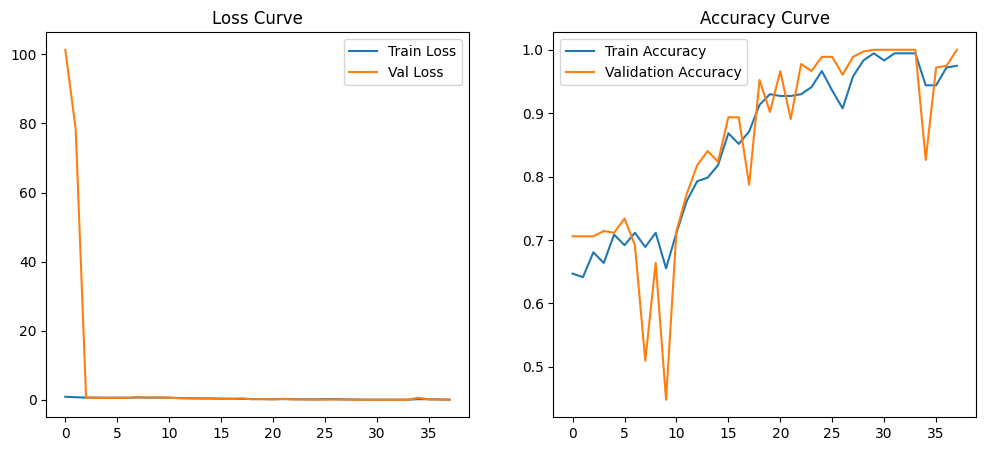

In [26]:
# ✅ Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

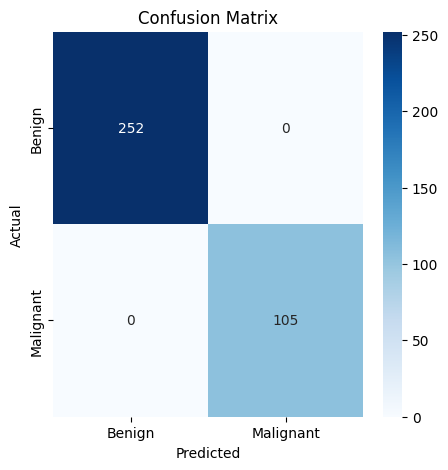


📜 Classification Report:

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       252
   Malignant       1.00      1.00      1.00       105

    accuracy                           1.00       357
   macro avg       1.00      1.00      1.00       357
weighted avg       1.00      1.00      1.00       357



In [27]:
# ✅ Confusion Matrix
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ Classification Report
print("\n📜 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


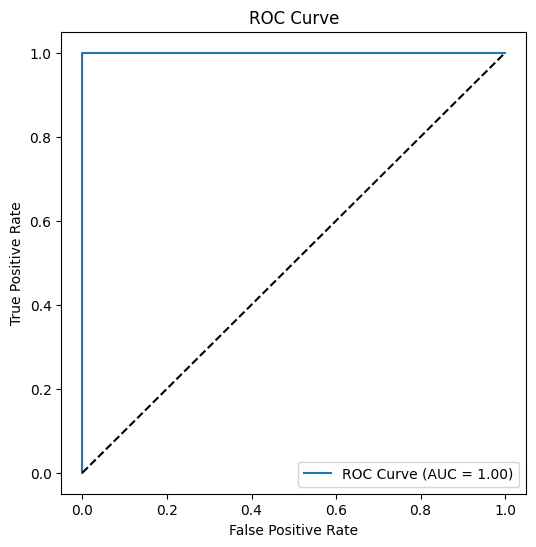

In [28]:
# ✅ ROC Curve
y_probs = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability for class 1
        y_probs.extend(probs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [29]:
import torch

# Save the model
model_path = "breast_cancer_model.pth"
torch.save(model.state_dict(), model_path)

# Download the model (for Kaggle)
import shutil
shutil.move(model_path, "/kaggle/working/breast_cancer_model.pth")

# If running locally, you can download manually
from IPython.display import FileLink
FileLink(model_path)


/kaggle/working/breast_cancer_model.pth